In [2]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
import seaborn as sns
from utils import *
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [1]:
BP = "../musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [3]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}' type=\"audio/wav\"></audio>".format(url))

In [8]:
# sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
sound_file = "short_206377.wav"
y, sr = librosa.load(sound_file)

Audio(url=sound_file)

# Sound as 1D-Signal

In [14]:
print(y)

[ 0.40872192  0.38845825  0.37365723 ...,  0.26812744  0.23779297
  0.21524048]


In [31]:
print(y.shape)
print(sr)

(220500,)
22050


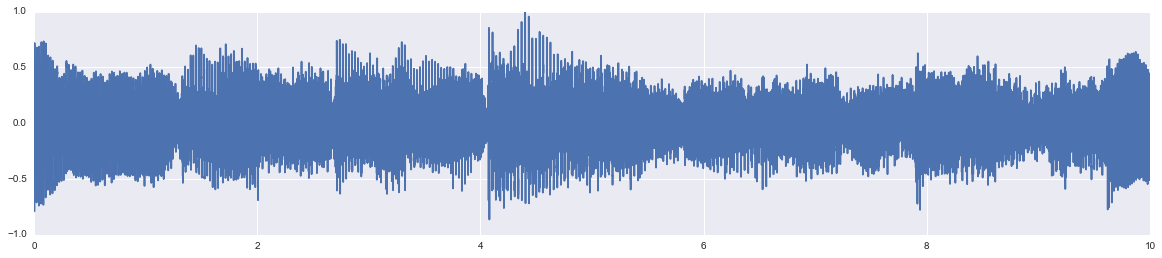

In [33]:
plt.figure(figsize=(20,4))
x = np.arange(0, 10, 10.0 / y.shape[0])
plt.plot(x, y)
pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [44]:
S = librosa.feature.melspectrogram(y, sr)
log_S = librosa.logamplitude(S**2, ref_power=np.max)

Нарисуйте спектрограмму, получилась красивая картинка?

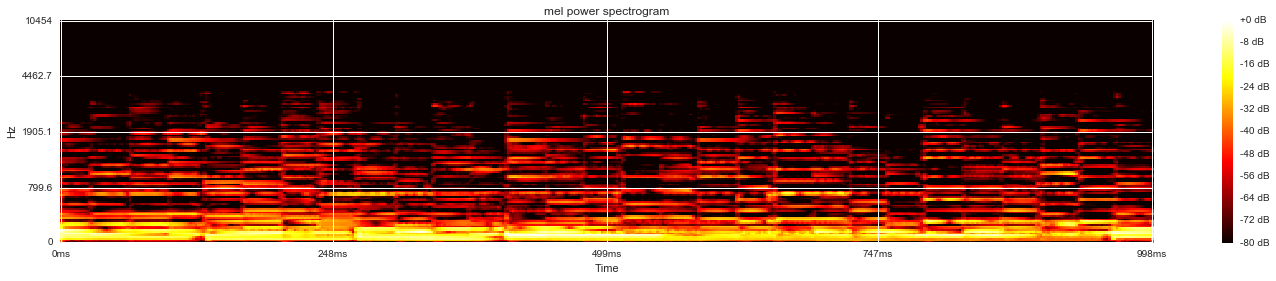

In [45]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=y.shape[0], x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

В этой секции мы создадим датасет, прочитав все данные.

In [3]:
import numpy as np

spectrograms_number = 6

def load(filenumber):
    return np.load(os.path.join(BP, "spectrograms", "spectrograms" + str(filenumber) + ".pcl"))

X_tuple = tuple(load(i) for i in range(1, spectrograms_number + 1))

In [4]:
X = np.concatenate(X_tuple)

Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [5]:
with open(os.path.join(BP, "train_genres.txt"), "rt") as f_in:
    train_genres = f_in.readlines()
    train_genres = [genre.rstrip() for genre in train_genres]
    train_genres = train_genres[:2000 * spectrograms_number]
    
num_classes = len(set(train_genres))
print(num_classes)

67


In [6]:
genres = list(set(train_genres))
genres_dict = {genres[i]: i for i in range(len(genres))}
genres_dict_back = {genre_id: genre for (genre, genre_id) in genres_dict.items()}

In [7]:
y = list(genres_dict[genre] for genre in train_genres)

In [8]:
print(X.shape[0])
print(len(y))

12000
12000


In [9]:
X_test = load(7)

# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [9]:
random.seed(123)
perm = np.random.permutation(len(y))

In [10]:
X_shuffled = X[perm]

In [11]:
y_shuffled = np.array(y)[perm]

In [12]:
Xreshape = X_shuffled.reshape(X_shuffled.shape[0], X_shuffled.shape[1], X_shuffled.shape[2])

In [13]:
print(X.shape)
print(X_shuffled.shape)

(12000, 128, 431)
(12000, 128, 431)


Разобьем датасет на трейн и валидацию 80/20%.

In [14]:
train_size = 10000

X_train, X_valid = Xreshape[:train_size], Xreshape[train_size:]
y_train, y_valid = y_shuffled[:train_size], y_shuffled[train_size:]

Попробуем поклассифицировать жанры методом ближайших соседей.

In [19]:
%%time

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=200)
clf = clf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)
y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], -1)))

print(accuracy_score(y_valid, y_val_pred))

0.316
CPU times: user 30min 54s, sys: 20.8 s, total: 31min 15s
Wall time: 31min 50s


In [20]:
%%time

y_test_pred = clf.predict(X_test.reshape((X_test.shape[0], -1)))

CPU times: user 30min 27s, sys: 21.9 s, total: 30min 48s
Wall time: 31min 31s


In [21]:
y_test_pred_genre = [genres_dict_back[genre_id] for genre_id in y_test_pred]

In [22]:
import pandas as pd

output = pd.DataFrame(
    data={'Id': range(12000, y_test_pred.shape[0] + 12000), 'Category': y_test_pred_genre} )

print(output[:10])

output.to_csv('results/result_kNN_X.csv', index=False, quoting=3)

  Category     Id
0      pop  12000
1     rock  12001
2      pop  12002
3      pop  12003
4     rock  12004
5      pop  12005
6      pop  12006
7      pop  12007
8      pop  12008
9      pop  12009


# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [ ]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

Перемешаем и разобьем датасет.

In [ ]:
random.seed(123)
perm = np.random.permutation(len(y))
X_shuffle, y_shuffle = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X_shuffle.reshape(X_shuffle.shape[0], 1, X_shuffle.shape[1], X_shuffle.shape[2])

train_size = X.shape[0] * 0.8

X_train, X_valid = Xreshape[:train_size], Xreshape[train_size:]
y_train, y_valid = y_shuffle[:train_size], y_shuffle[train_size:]

X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

In [ ]:
# Не импортилось =\
def categorical_accuracy(predictions, targets, top_k=1):
    if targets.ndim == predictions.ndim:
        targets = theano.tensor.argmax(targets, axis=-1)
    elif targets.ndim != predictions.ndim - 1:
        raise TypeError('rank mismatch between targets and predictions')

    if top_k == 1:
        # standard categorical accuracy
        top = theano.tensor.argmax(predictions, axis=-1)
        return theano.tensor.eq(top, targets)
    else:
        # top-k accuracy
        top = theano.tensor.argsort(predictions, axis=-1)
        # (Theano cannot index with [..., -top_k:], we need to simulate that)
        top = top[[slice(None) for _ in range(top.ndim - 1)] +
                  [slice(-top_k, None)]]
        targets = theano.tensor.shape_padaxis(targets, axis=-1)
        return theano.tensor.any(theano.tensor.eq(top, targets), axis=-1)

In [16]:
from lasagne.layers import InputLayer, DenseLayer
# from lasagne.objectives import categorical_accuracy

input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = InputLayer(shape=(None, 1, X.shape[1], X.shape[2]), input_var=input_X) 

# nn = DenseLayer(nn, num_units = 50)
nn = DenseLayer(nn, num_units = num_classes, nonlinearity=T.nnet.softmax)
nn = DenseLayer(nn, num_units = num_classes, nonlinearity=T.nnet.softmax)
# nn = DenseLayer(nn, num_units = 100, nonlinearity=T.nnet.softmax)

y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [17]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [19]:
%%time
# 1 слой
conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=50, batch_size=50)

Epoch   1 of  50 train_loss = 8740.24 val_loss = 9430.43 train_acc = 11.44 val_acc = 38.25
Epoch   2 of  50 train_loss = 7818.54 val_loss = 5158.02 train_acc = 15.62 val_acc = 5.25
Epoch   3 of  50 train_loss = 4209.78 val_loss = 4094.03 train_acc = 13.31 val_acc = 2.25
Epoch   4 of  50 train_loss = 4296.88 val_loss = 3601.21 train_acc = 15.50 val_acc = 9.75
Epoch   5 of  50 train_loss = 3431.05 val_loss = 3484.81 train_acc = 17.06 val_acc = 38.25
Epoch   6 of  50 train_loss = 3248.69 val_loss = 2416.45 train_acc = 18.81 val_acc = 11.25
Epoch   7 of  50 train_loss = 2365.52 val_loss = 2743.84 train_acc = 17.75 val_acc = 35.50
Epoch   8 of  50 train_loss = 2712.46 val_loss = 2094.14 train_acc = 19.19 val_acc = 6.50
Epoch   9 of  50 train_loss = 2719.98 val_loss = 3173.55 train_acc = 17.38 val_acc = 4.00
Epoch  10 of  50 train_loss = 2611.35 val_loss = 2392.45 train_acc = 20.37 val_acc = 1.25
Epoch  11 of  50 train_loss = 2044.60 val_loss = 1876.34 train_acc = 19.81 val_acc = 37.50
Epoch

In [18]:
%%time
# 2 слоя
conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=20, batch_size=50)

Epoch   1 of  20 train_loss = 4.01 val_loss = 3.81 train_acc = 10.84 val_acc = 34.46
Epoch   2 of  20 train_loss = 3.64 val_loss = 3.49 train_acc = 35.18 val_acc = 34.46
Epoch   3 of  20 train_loss = 3.35 val_loss = 3.24 train_acc = 35.18 val_acc = 34.46
Epoch   4 of  20 train_loss = 3.14 val_loss = 3.06 train_acc = 35.18 val_acc = 34.46
Epoch   5 of  20 train_loss = 2.98 val_loss = 2.93 train_acc = 35.18 val_acc = 34.46
Epoch   6 of  20 train_loss = 2.87 val_loss = 2.84 train_acc = 35.18 val_acc = 34.46
Epoch   7 of  20 train_loss = 2.79 val_loss = 2.78 train_acc = 35.18 val_acc = 34.46
Epoch   8 of  20 train_loss = 2.74 val_loss = 2.74 train_acc = 35.18 val_acc = 34.46
Epoch   9 of  20 train_loss = 2.71 val_loss = 2.72 train_acc = 35.18 val_acc = 34.46
Epoch  10 of  20 train_loss = 2.69 val_loss = 2.70 train_acc = 35.18 val_acc = 34.46
Epoch  11 of  20 train_loss = 2.68 val_loss = 2.69 train_acc = 35.18 val_acc = 34.46
Epoch  12 of  20 train_loss = 2.67 val_loss = 2.69 train_acc = 35

In [29]:
%%time
# 3 слоя
conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=50, batch_size=50)

Epoch   1 of  50 train_loss = 4.56 val_loss = 4.51 train_acc = 33.56 val_acc = 38.25
Epoch   2 of  50 train_loss = 4.47 val_loss = 4.43 train_acc = 35.88 val_acc = 38.25
Epoch   3 of  50 train_loss = 4.39 val_loss = 4.34 train_acc = 35.88 val_acc = 38.25
Epoch   4 of  50 train_loss = 4.31 val_loss = 4.26 train_acc = 35.88 val_acc = 38.25
Epoch   5 of  50 train_loss = 4.23 val_loss = 4.18 train_acc = 35.88 val_acc = 38.25
Epoch   6 of  50 train_loss = 4.15 val_loss = 4.11 train_acc = 35.88 val_acc = 38.25
Epoch   7 of  50 train_loss = 4.08 val_loss = 4.03 train_acc = 35.88 val_acc = 38.25
Epoch   8 of  50 train_loss = 4.01 val_loss = 3.96 train_acc = 35.88 val_acc = 38.25
Epoch   9 of  50 train_loss = 3.93 val_loss = 3.89 train_acc = 35.88 val_acc = 38.25
Epoch  10 of  50 train_loss = 3.87 val_loss = 3.82 train_acc = 35.88 val_acc = 38.25
Epoch  11 of  50 train_loss = 3.80 val_loss = 3.76 train_acc = 35.88 val_acc = 38.25
Epoch  12 of  50 train_loss = 3.73 val_loss = 3.69 train_acc = 35

In [19]:
y_predicted = lasagne.layers.get_output(conv_nn)
y_classes = y_predicted.argmax(axis=1)
get_output = theano.function([input_X], y_classes, allow_input_downcast=True)
y_test_pred = get_output(X_test_reshaped)
y_test_pred_genre = [genres_dict_back[genre_id] for genre_id in y_test_pred]

In [21]:
print (y_test_pred_genre[:30])

['pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop']


In [22]:
test_pred_genre_set = list(set(y_test_pred_genre))
print(test_pred_genre_set)

['pop']


In [45]:
import pandas as pd

output = pd.DataFrame(
    data={'Id': range(12000, y_test_pred.shape[0] + 12000), 'Category': y_test_pred_genre} )

print(output[:10])

output.to_csv('results/result_DenseLayer_X.csv', index=False, quoting=3)

  Category     Id
0      pop  12000
1      pop  12001
2      pop  12002
3      pop  12003
4      pop  12004
5      pop  12005
6      pop  12006
7      pop  12007
8      pop  12008
9      pop  12009


# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [10]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

In [11]:
# Не импортилось =\
def categorical_accuracy(predictions, targets, top_k=1):
    if targets.ndim == predictions.ndim:
        targets = theano.tensor.argmax(targets, axis=-1)
    elif targets.ndim != predictions.ndim - 1:
        raise TypeError('rank mismatch between targets and predictions')

    if top_k == 1:
        # standard categorical accuracy
        top = theano.tensor.argmax(predictions, axis=-1)
        return theano.tensor.eq(top, targets)
    else:
        # top-k accuracy
        top = theano.tensor.argsort(predictions, axis=-1)
        # (Theano cannot index with [..., -top_k:], we need to simulate that)
        top = top[[slice(None) for _ in range(top.ndim - 1)] +
                  [slice(-top_k, None)]]
        targets = theano.tensor.shape_padaxis(targets, axis=-1)
        return theano.tensor.any(theano.tensor.eq(top, targets), axis=-1)

In [12]:
random.seed(123)
perm = np.random.permutation(len(y))
X_shuffle, y_shuffle = np.array(X)[perm].astype('float32'), np.array(y)[perm]
X_shuffle, y_shuffle = np.array(X_shuffle)[perm].astype('float32'), np.array(y_shuffle)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

train_size = X_shuffle.shape[0] * 0.8

X_train, X_valid = X_shuffle[:train_size], Xreshape[train_size:]
y_train, y_valid = y_shuffle[:train_size], y_shuffle[train_size:]

In [13]:
from lasagne.layers import InputLayer, Conv1DLayer, MaxPool1DLayer, DenseLayer, GlobalPoolLayer, DropoutLayer

input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 

nn = Conv1DLayer(nn, num_filters=16, filter_size=4, nonlinearity = lasagne.nonlinearities.rectify)
nn = MaxPool1DLayer(nn, pool_size=4)
nn = Conv1DLayer(nn, num_filters=16, filter_size=4, nonlinearity = lasagne.nonlinearities.rectify)
nn = MaxPool1DLayer(nn, pool_size=2)
nn = Conv1DLayer(nn, num_filters=32, filter_size=4, nonlinearity = lasagne.nonlinearities.rectify)
nn = GlobalPoolLayer(nn)
nn = DropoutLayer(nn, p = 0.2)
nn = DenseLayer(nn, 256)
nn = DropoutLayer(nn, p = 0.2)
nn = DenseLayer(nn, num_classes, nonlinearity=lasagne.nonlinearities.softmax)

In [14]:
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [15]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [16]:
nn_all = []
nn_all += [nn]
nn_index = 0

In [17]:
# %%time 
for i in range(100):
    print(nn_index + 1, end=' ')
    nn_all += [train_net(nn_all[nn_index], train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=5, batch_size=50)]
    nn_index += 1

1 Epoch   1 of   5 train_loss = 2.88 val_loss = 2.74 train_acc = 34.05 val_acc = 34.67
Epoch   2 of   5 train_loss = 2.70 val_loss = 2.71 train_acc = 35.11 val_acc = 34.67
Epoch   3 of   5 train_loss = 2.67 val_loss = 2.70 train_acc = 35.11 val_acc = 34.71
Epoch   4 of   5 train_loss = 2.62 val_loss = 2.74 train_acc = 35.06 val_acc = 34.13
Epoch   5 of   5 train_loss = 2.57 val_loss = 2.82 train_acc = 35.36 val_acc = 30.79
2 Epoch   1 of   5 train_loss = 2.53 val_loss = 2.85 train_acc = 35.52 val_acc = 31.58
Epoch   2 of   5 train_loss = 2.50 val_loss = 2.85 train_acc = 35.91 val_acc = 31.42
Epoch   3 of   5 train_loss = 2.47 val_loss = 2.88 train_acc = 36.16 val_acc = 32.17
Epoch   4 of   5 train_loss = 2.44 val_loss = 2.97 train_acc = 36.14 val_acc = 29.00
Epoch   5 of   5 train_loss = 2.43 val_loss = 2.87 train_acc = 36.07 val_acc = 33.29
3 Epoch   1 of   5 train_loss = 2.41 val_loss = 2.96 train_acc = 36.36 val_acc = 31.83
Epoch   2 of   5 train_loss = 2.39 val_loss = 2.94 train_ac

In [97]:
y_predicted = lasagne.layers.get_output(nn_all[2])
y_classes = y_predicted.argmax(axis=1)
get_output = theano.function([input_X], y_classes, allow_input_downcast=True)
y_test_pred = get_output(X_test)
y_test_pred_genre = [genres_dict_back[genre_id] for genre_id in y_test_pred]

In [98]:
test_pred_genre_set = list(set(y_test_pred_genre))
print(test_pred_genre_set)

['soundtrack', 'newage', 'blues', 'soul', 'reggae', 'trance', 'rusrap', 'estrada', 'eastern', 'pop', 'punk', 'techno', 'latinfolk', 'relax', 'dance', 'classical', 'shanson', 'folk', 'prog', 'dnb', 'rap', 'lounge', 'bard', 'indie', 'electronics', 'rock', 'house', 'rusrock', 'rnb', 'meditation', 'alternative', 'other', 'metal', 'jazz', 'rusfolk', 'eurofolk', 'modern']


In [99]:
import pandas as pd

output = pd.DataFrame(
    data={'Id': range(12000, y_test_pred.shape[0] + 12000), 'Category': y_test_pred_genre} )

print(output[:10])

output.to_csv('results/result_ConvolutionNet_X.csv', index=False, quoting=3)

      Category     Id
0          pop  12000
1  alternative  12001
2      eastern  12002
3          pop  12003
4          pop  12004
5          pop  12005
6         rock  12006
7          pop  12007
8          pop  12008
9          pop  12009


Валидационная точность должна быть около 0.6 или лучше. 

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

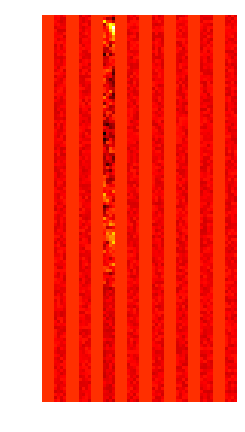

In [24]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [23]:
from sklearn.manifold import TSNE

In [24]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [26]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = list(map(f, X_train)) + list(map(f, X_valid))
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [77]:
X_tsne = TSNE(n_components=2, random_state=0)
track_vectors_tsne = X_tsne.fit_transform(track_vectors) 

In [78]:
print(track_vectors_tsne[:10])

[[ -5.31634582  -6.99139787]
 [ -5.64008617  -6.43537466]
 [  9.43120763  -1.24980308]
 [  9.42852026  -1.22489806]
 [ -1.44248922   3.136648  ]
 [ 10.52801804  -0.23534367]
 [  9.54438482  -3.97414361]
 [  9.44305673   2.14898119]
 [ -5.36071041   7.18209037]
 [  8.22668418  -0.53369995]]


In [79]:
track_vectors_tsne_1 = [q[0] for q in track_vectors_tsne]
track_vectors_tsne_2 = [q[1] for q in track_vectors_tsne]

In [80]:
print(track_vectors_tsne_1[:10])
print(track_vectors_tsne_2[:10])

[-5.3163458242708064, -5.6400861692729061, 9.4312076279991093, 9.4285202610194059, -1.4424892246981438, 10.528018042958792, 9.5443848153315329, 9.4430567300310653, -5.3607104082094983, 8.2266841817741234]
[-6.9913978741106897, -6.4353746553957665, -1.2498030770721522, -1.2248980557035156, 3.136647997613581, -0.23534366684189356, -3.97414360965863, 2.1489811855634571, 7.1820903664265412, -0.5336999471515268]


In [81]:
print(track_labels[:10])

[17 17  9  9 43  9  9  9 54  9]


In [82]:
print(len(track_vectors_tsne_1))
print(len(track_vectors_tsne_2))
print(len(track_labels))

6000
6000
6000


нарисуйте получившиеся точки

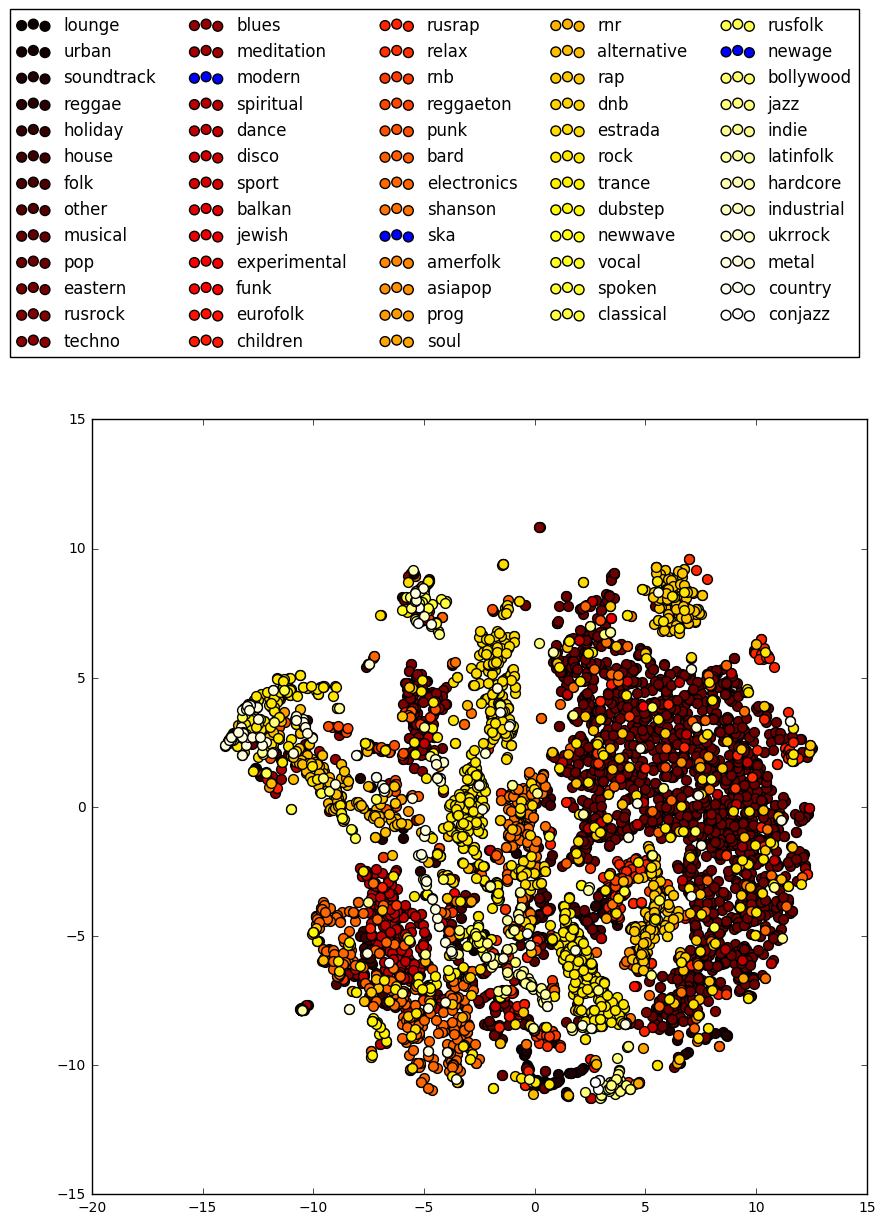

In [83]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(genres_dict_back)))

for idx, gener in genres_dict_back.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(np.take(track_vectors_tsne_1,idx_), np.take(track_vectors_tsne_2,idx_), s=50, c=colors[idx], cmap=cm.hot, label=gener)

pylab.legend(loc=0, ncol=5, bbox_to_anchor=(0., 1.02, 1., 0.52))